From Kaggle: "MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike."

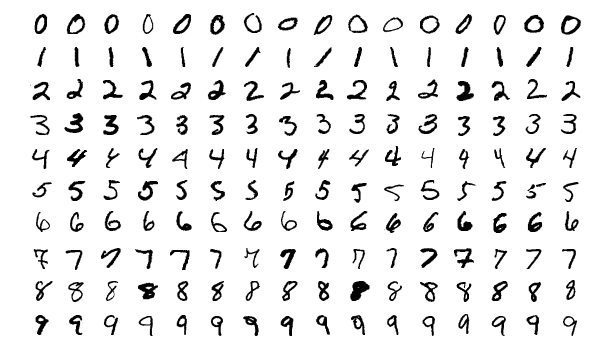

In [82]:
!pip install torch torchvision

In [0]:
#Import Libraries

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

import seaborn as sns;
import matplotlib.pyplot as plt
import pandas as pd

color = sns.color_palette()
sns.set_style('darkgrid')

In [0]:
args={}
kwargs={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=20  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.2 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).
args['gamma'] = 0.7  #Learning rate step gamma (default: 0.7)

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=True

device = torch.device("cuda" if args['cuda'] else "cpu")

In [0]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)

convnet

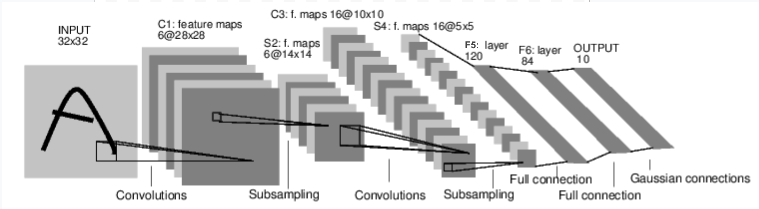

In [0]:
size_input_layer = 9216 # 764
size_hidden_layer_1 = 512
size_hidden_layer_2 = 128
size_output_layer = 10

In [0]:
class FeedforwardNet(nn.Module):
    def __init__(self):
        super(FeedforwardNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        # self.fc1 = nn.Linear(9216, 128)
        # self.fc2 = nn.Linear(128, 10)
        self.fc1 = nn.Linear(size_input_layer, size_hidden_layer_1)
        self.fc2 = nn.Linear(size_hidden_layer_1, size_hidden_layer_2)
        self.fc3 = nn.Linear(size_hidden_layer_2, size_output_layer)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output


In [0]:
train_acc = []
test_acc = []
loss = []

In [0]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            # train_acc.append()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [0]:
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    test_correct = 0
    train_correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            test_correct += pred.eq(target.view_as(pred)).sum().item()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            train_correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    loss.append(test_loss)
    test_acc.append(100. * test_correct / len(test_loader.dataset))
    train_acc.append(100. * train_correct / len(train_loader.dataset))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset),
        100. * test_correct / len(test_loader.dataset)))

In [91]:
model = FeedforwardNet().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args['lr'])

# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

scheduler = StepLR(optimizer, step_size=1, gamma=args['gamma'])
for epoch in range(1, args['epochs'] + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)
    scheduler.step()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305625
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.534521
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.875628
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.783592
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.504536
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.427036

Test set: Average loss: 0.2887, Accuracy: 9147/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.301877
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.339384
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.237505
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.242600
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.236254
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.266873

Test set: Average loss: 0.1897, Accuracy: 9414/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.229993
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.183844
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.228740
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.211359
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.138146
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.

In [92]:
print(train_acc)
print(test_acc)
print(loss)

[91.08333333333333, 93.91833333333334, 95.38666666666667, 96.055, 96.505, 96.71, 96.90333333333334, 96.95666666666666, 97.015, 97.02833333333334, 97.07333333333334, 97.09333333333333, 97.11333333333333, 97.12, 97.13833333333334, 97.14333333333333, 97.14333333333333, 97.14333333333333, 97.145, 97.14666666666666]
[91.47, 94.14, 95.42, 96.24, 96.53, 96.67, 96.82, 96.99, 97.02, 97.04, 97.06, 97.08, 97.1, 97.1, 97.11, 97.13, 97.14, 97.12, 97.11, 97.1]
[0.2887171768188477, 0.18970142211914062, 0.14584409103393556, 0.12699316482543946, 0.11493341217041016, 0.1080973487854004, 0.10399157791137695, 0.10162729644775391, 0.10026405639648438, 0.09896830444335937, 0.09778060455322266, 0.09733960266113281, 0.0972274070739746, 0.09694267044067383, 0.09666937484741212, 0.09650839233398438, 0.09639694137573242, 0.09632968368530273, 0.09628251647949218, 0.09624591445922852]


In [93]:
epochs = []
for i in range(1,21):
  epochs.append(i)
epochs

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [0]:
data = pd.DataFrame(list(zip(epochs, loss, train_acc, test_acc)), columns =['epochs', 'loss', 'train_acc', 'test_acc'])

In [95]:
data.head()

,epochs,loss,train_acc,test_acc
0,1,0.288717,91.083333,91.47
1,2,0.189701,93.918333,94.14
2,3,0.145844,95.386667,95.42
3,4,0.126993,96.055000,96.24
4,5,0.114933,96.505000,96.53


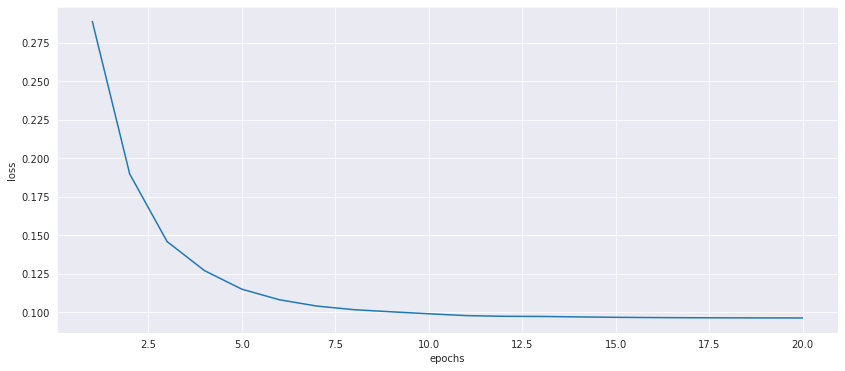

In [96]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(x="epochs", y="loss", data=data)

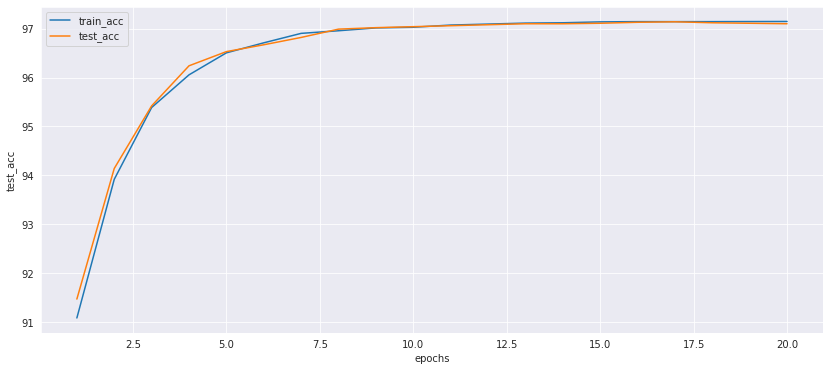

In [97]:
plt.figure(figsize=(14, 6))

sns.lineplot('epochs', 'train_acc', data=data, label='train_acc')
sns.lineplot('epochs', 'test_acc', data=data, label='test_acc')
    
plt.legend()